In [1]:
#Importing necessary libraries and packages
import pandas as pd 
import numpy as np 

import seaborn as sns              # For Visualization 
import matplotlib.pyplot as plt    # ploting package
%matplotlib inline
import matplotlib.ticker as plticker


import warnings                    # Filtering warnings
warnings.filterwarnings('ignore')

import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
#Loading the Training dataset

#Importing and reading the csv file into dataframe df
df = pd.read_csv(r"D:\Malignant-Comments-Classifier-Project\Malignant Comments Classifier Project\train.csv")

print(df.shape)                   #Printing shape of dataframe

(159571, 8)


We can see the train dataset has 159571 rows and 8 columns. 

In [3]:
#Loading the Test dataset

#Importing and reading the csv file into dataframe df
df_test=pd.read_csv(r"D:\Malignant-Comments-Classifier-Project\Malignant Comments Classifier Project\test.csv") 

print(df_test.shape)

(153164, 2)


Here we can see the dataset ha only 23 columns and 153164 rows. 

# Exploratory Data Analysis (EDA)

In [4]:
pd.set_option('display.max_columns',None)    # This will help us to see truncated columns
df.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


We can see the comments are marked as malignant, highly_malignant, rude, threat, abuse and loathe using binary class of Yes (1) & No (0).

In [5]:
# Sorting out columns for datatypes in our  our training set
df.columns.to_series().groupby(df.dtypes).groups

{int64: ['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe'], object: ['id', 'comment_text']}

In [6]:
#Checking the list of fields in our train dataset
print(df.dtypes)

id                  object
comment_text        object
malignant            int64
highly_malignant     int64
rude                 int64
threat               int64
abuse                int64
loathe               int64
dtype: object


We observe that the columns id & comment_text comes with object datatypes and rest of features comes with integer datatypes.

Let's proceed forward by checking the null values in the dataset.

In [7]:
df.isnull().sum().any()

False

In [8]:
df_test.isnull().sum().any()

False

We can see both train and test datset shows nulls as False, which means, there are no missing values. Looks good!

Now, let us find out how a comment looks like.

In [9]:
df['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

By observing the above comment we can say that we need to do lot of text processing as there are many unimportant words as well as numbers and other stuff that can meddle with proper prediction.

We will next perform an exploration of the data present in the target variables. 

In [10]:
Categorical = ['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe']

In [11]:
for i in df.columns[2:]:
    print('Value Counts of',i)
    print(df[i].value_counts())
    print('='*100)

Value Counts of malignant
0    144277
1     15294
Name: malignant, dtype: int64
Value Counts of highly_malignant
0    157976
1      1595
Name: highly_malignant, dtype: int64
Value Counts of rude
0    151122
1      8449
Name: rude, dtype: int64
Value Counts of threat
0    159093
1       478
Name: threat, dtype: int64
Value Counts of abuse
0    151694
1      7877
Name: abuse, dtype: int64
Value Counts of loathe
0    158166
1      1405
Name: loathe, dtype: int64


The above data reveals that our dataset is imbalanced. Thus, we will have to handle with care in order to make predictions. 

# Data Visualization

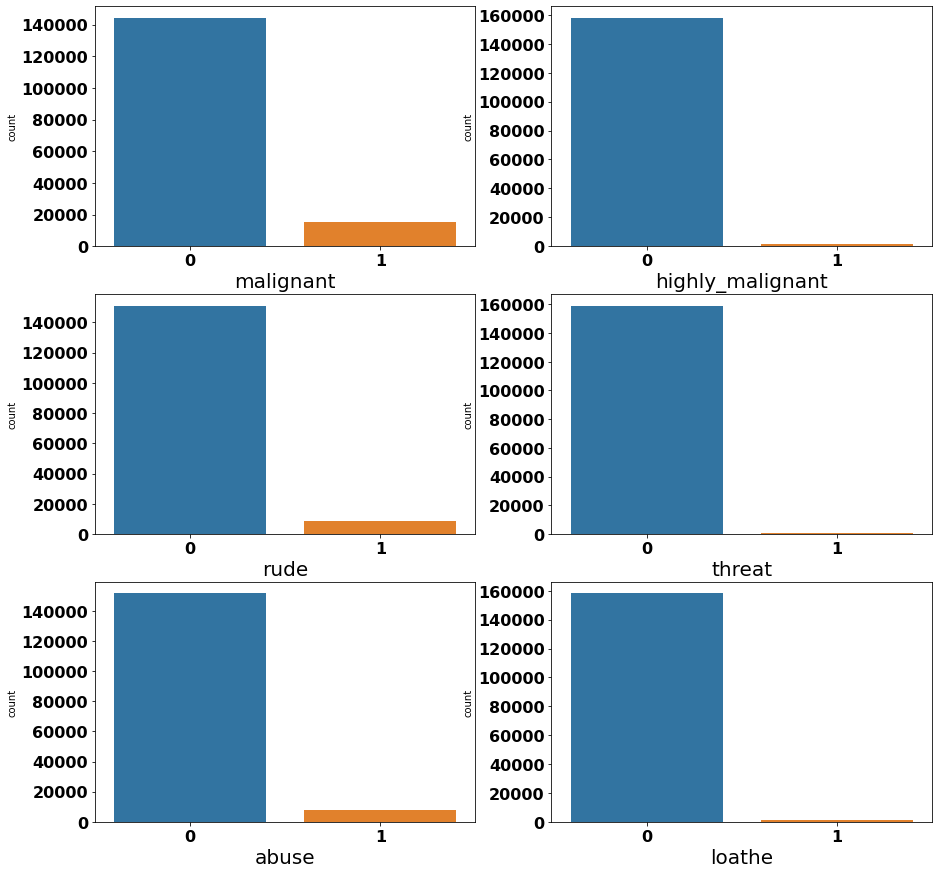

In [12]:
# Plotting countplot for all the features
categories=df.columns[2:]
plt.figure(figsize=(15,15),facecolor='white')
plotnumber=1
for col in categories:
    if plotnumber<=6:
        ax=plt.subplot(3,2,plotnumber)
        sns.countplot(df[col])
        plt.xlabel(col,fontsize=20)
        plt.xticks(fontsize=16,fontweight ='bold')
        plt.yticks(fontsize=16,fontweight ='bold')
    plotnumber += 1
plt.show()

Observation:

-The data is highly imbalanced. 

-We can see maximum Negative comments are categorized as Malignant, and there are also a lot of comments that are abusive and rude. However, threat comments are minimum.

In [13]:
#Checking the percentage of the comments
none = df[(df['malignant']!=1) & (df['highly_malignant']!=1) & (df['rude']!=1) & 
                            (df['threat']!=1) & (df['abuse']!=1) & (df['loathe']!=1)]
percent=len(none)/len(df)*100
print('Percentage of good/neutral comments = ',percent)
print('Percentage of negative comments = ', (100-percent))

Percentage of good/neutral comments =  89.83211235124176
Percentage of negative comments =  10.167887648758239


We can see almost 90% comments are Good/Neutral while the remaining 10% comments are Negative.

In [14]:
#Create a new subset of the data by only taking the 2nd column onwards (comments and categories)
data_count = df.iloc[:,2:].sum()

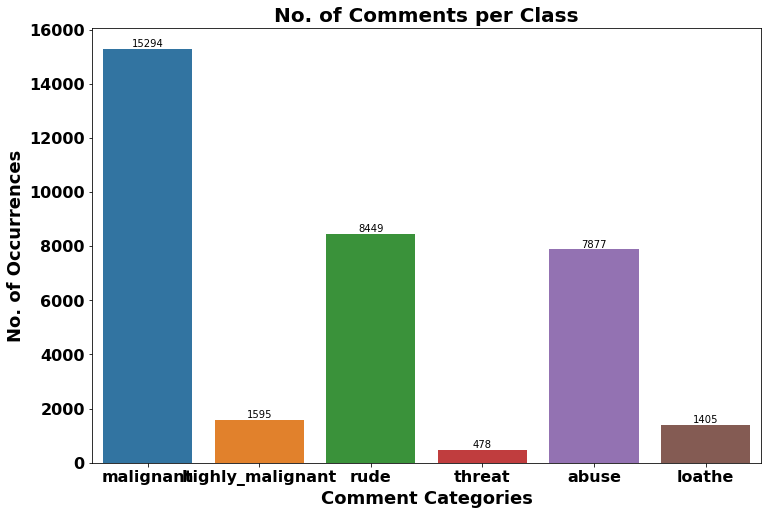

In [15]:
# Plot a chart with the following size
plt.figure(figsize=(12,8))

# Plot a bar chart using the index (category values) and the count of each category.
ax = sns.barplot(data_count.index, data_count.values)

plt.title("No. of Comments per Class", fontsize=20, fontweight='bold')
plt.ylabel('No. of Occurrences', fontsize=18,fontweight='bold')
plt.xlabel('Comment Categories', fontsize=18,fontweight='bold')
plt.xticks(fontsize=16,fontweight ='bold')
plt.yticks(fontsize=16,fontweight ='bold')
rects = ax.patches
labels = data_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

Obsevartion:

-Out of total Negative comments, majority of negative comments are Malignant in nature followed by rude categories.

-There are very few comments that are threatening in nature.

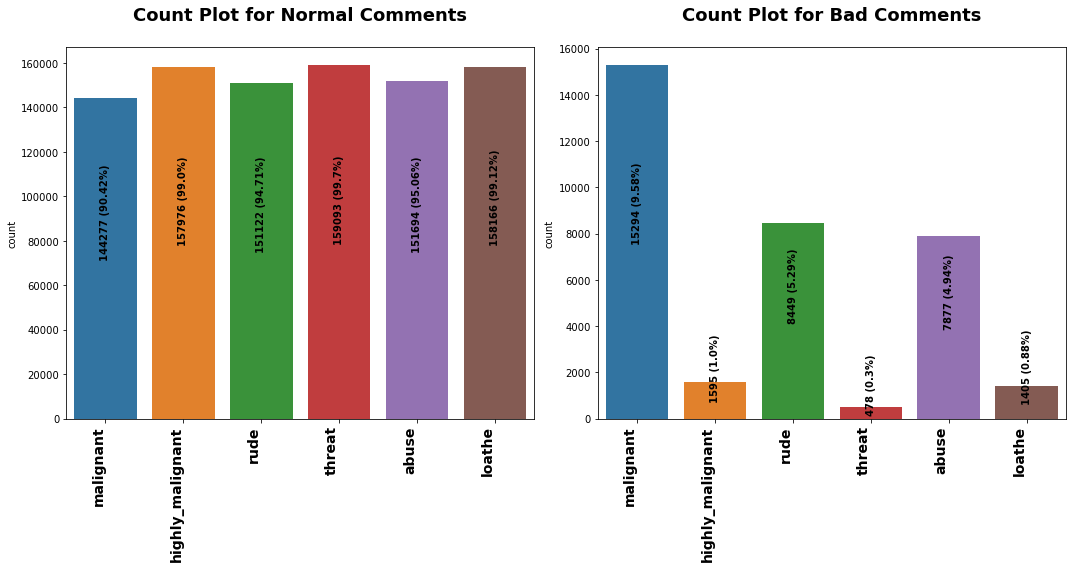

In [16]:
# comparing normal comments and bad comments using count plot

fig, ax = plt.subplots(1,2,figsize=(15,8))

for i in range(2):
    sns.countplot(data=df[df.columns[2:]][df[df.columns[2:]]==i], ax=ax[i])
    if i == 0:
        ax[i].set_title("Count Plot for Normal Comments\n", fontsize=18, fontweight='bold')
    else:
        ax[i].set_title("Count Plot for Bad Comments\n", fontsize=18, fontweight='bold')
        
    ax[i].set_xticklabels(df.columns[2:], rotation=90, ha="right", fontsize=14, fontweight='bold')
    p=0
    for prop in ax[i].patches:
        count = prop.get_height()
        s = f"{count} ({round(count*100/len(df),2)}%)"
        ax[i].text(p,count/2,s,rotation=90, ha="center", fontweight="bold")
        p += 1
plt.tight_layout()
plt.show()

The above plot shows the distribution of both normal and bad comments side by side. 

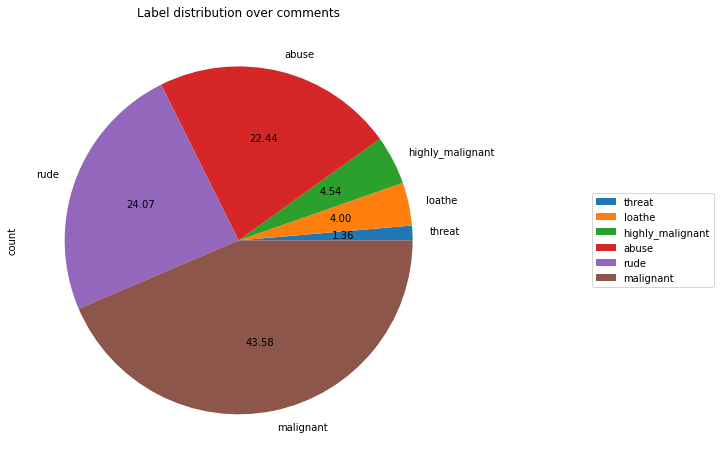

In [17]:
#Visualizing the label distribution of comments using pie chart
comments_labels = ['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe']
df_distribution = df[df.columns[2:]].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

df_distribution.plot.pie(y = 'count', title = 'Label distribution over comments',
                         autopct='%2.2f', figsize = (8,8))\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5))
plt.show()

Observation :

-Its evident that around 90% comments are Good/Neutral while the rest 10% comments are Negative in nature.

-Out of total negative comments 43.58% are malignant followed by 24.07% are rude comments.

In [18]:
comment_len = df.comment_text.str.len()
df.comment_text.str.len().median()

205.0

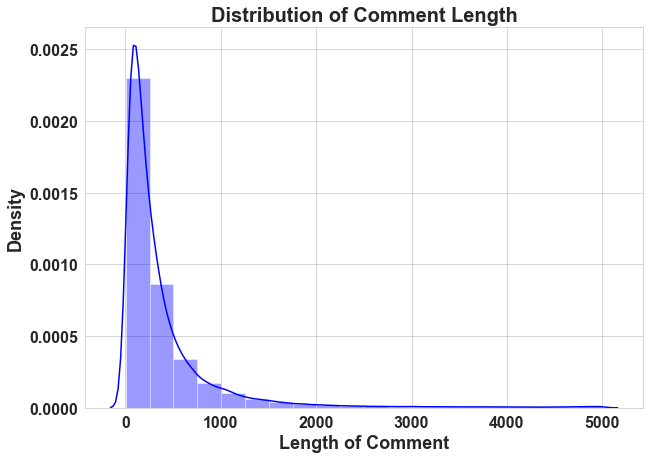

In [19]:
#Distribution of comments length
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
comment_len = df.comment_text.str.len()
sns.distplot(comment_len, bins=20, color = 'blue')

plt.title("Distribution of Comment Length", fontsize=20, fontweight='bold')
plt.ylabel('Density', fontsize=18,fontweight='bold')
plt.xlabel('Length of Comment', fontsize=18,fontweight='bold')
plt.xticks(fontsize=16,fontweight ='bold')
plt.yticks(fontsize=16,fontweight ='bold')
plt.show()

Observation:
    
-We see most of the comments are short with only a few comments longer than 1000 words. 

-Majority of the comments are of length 500, where maximum length is 5000 and minimum length is 5. 

-Median length being 250.

In [20]:
#Checking correlation of the dataset
corr=df.corr()  
corr

,malignant,highly_malignant,rude,threat,abuse,loathe
malignant,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
highly_malignant,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
rude,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
abuse,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
loathe,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


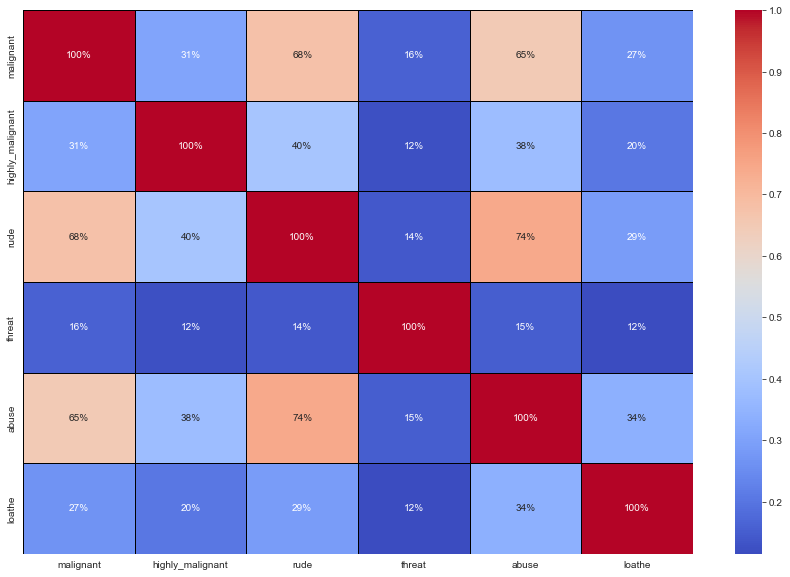

In [21]:
# Plotting heatmap for visualizing the correlation
plt.figure(figsize=(15, 10))
corr = df.corr() # corr() function provides the correlation value of each column
sns.heatmap(corr, linewidth=0.5, linecolor='black', fmt='.0%', cmap='coolwarm', annot=True)
plt.show()

Observation:
    
-The highest positive correlation is seen in between fields 'rude' and 'abuse'.

-Attribute 'threat' is negatively correlated with each and every other feature of this training dataset.

-Almost all variable are correlated with each other negatively.

# Data pre-processing

In [22]:
#As ID is not much important, we can drop from the dataset
df.drop('id',axis=1,inplace=True)
df_test.drop('id',axis=1,inplace=True)

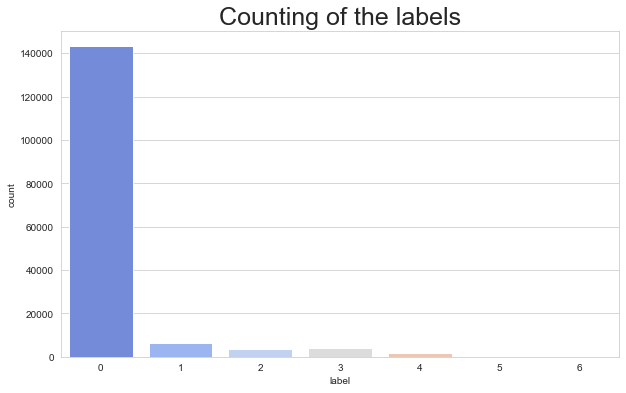

In [23]:
#Checking the count of labels
df['label']=df[comments_labels].sum(axis=1)
plt.figure(figsize=(10,6))
sns.countplot(df['label'], palette='coolwarm')
plt.title('Counting of the labels',fontsize=25)
plt.show()

We will do Feature Extraction for length before cleaning the training dataset.

In [24]:
# Creating a column 'length_before_cleaning' in training dataset
# It represents the length of the each comment respectively in a column 'comment_text' 
df['length_before_cleaning'] = df['comment_text'].map(lambda comment_text: len(comment_text))
df

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label,length_before_cleaning
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,264
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,112
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,233
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,622
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,67
...,...,...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,0,295
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,0,99
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,0,81
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0,0,116


We will now do Feature Extraction for length before cleaning in the testing dataset.

In [25]:
# Creating a column 'length_before_cleaning' in test dataset
# It represents the length of the each comment respectively in a column 'comment_text' 
df_test['length_before_cleaning'] = df_test['comment_text'].map(lambda comment_text: len(comment_text))
df_test.head(5)

,comment_text,length_before_cleaning
0,Yo bitch Ja Rule is more succesful then you'll...,367
1,== From RfC == \n\n The title is fine as it is...,50
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",54
3,":If you have a look back at the source, the in...",205
4,I don't anonymously edit articles at all.,41


# Text Mining
Operation perform are as followed:

-Removing Punctuations and other special characters

-Word Tokenzation

-Removing Stop Words

-Stemming and Lemmatising

-Applying Count Vectorizer

In [26]:
#Defining the stop words
stop_words = stopwords.words('english')

#Defining the lemmatizer
lemmatizer = WordNetLemmatizer()

In [27]:
#Replacing '\n' in comment_text
df['comment_text'] = df['comment_text'].replace('\n',' ')

In [28]:
#Function Definition for using regex operations and other text preprocessing for getting cleaned texts
def clean_comments(text):
    
    #convert to lower case
    lowered_text = text.lower()
    
    #Replacing email addresses with 'emailaddress'
    text = re.sub(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress', lowered_text)
    
    #Replace URLs with 'webaddress'
    text = re.sub(r'http\S+', 'webaddress', text)
    
    #Removing numbers
    text = re.sub(r'[0-9]', " ", text)
    
    #Removing the HTML tags
    text = re.sub(r"<.*?>", " ", text)
    
    #Removing Punctuations
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\_',' ',text)
    
    #Removing all the non-ascii characters 
    clean_words = re.sub(r'[^\x00-\x7f]',r'', text)
    
    #Removing the unwanted white spaces
    text = " ".join(text.split()) 
    
    #Splitting data into words
    tokenized_text = word_tokenize(text)
    
    #Removing remaining tokens that are not alphabetic, Removing stop words and Lemmatizing the text
    removed_stop_text = [lemmatizer.lemmatize(word) for word in tokenized_text if word not in stop_words if word.isalpha()]
   
    return " ".join(removed_stop_text)

In [29]:
# Calling the above function for the column comment_text in training dataset to replace original with cleaned text
df['comment_text'] = df['comment_text'].apply(clean_comments)
df['comment_text'].head()

0    explanation edits made username hardcore metal...
1    aww match background colour seemingly stuck th...
2    hey man really trying edit war guy constantly ...
3    make real suggestion improvement wondered sect...
4                        sir hero chance remember page
Name: comment_text, dtype: object

In [30]:
# Creating a column 'len_after_cleaning'
# Representing the length of the each comment respectively in a column 'comment_text' after cleaning the text.
df['length_after_cleaning'] = df['comment_text'].map(lambda comment_text: len(comment_text))
df.head()

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label,length_before_cleaning,length_after_cleaning
0,explanation edits made username hardcore metal...,0,0,0,0,0,0,0,264,156
1,aww match background colour seemingly stuck th...,0,0,0,0,0,0,0,112,67
2,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,0,233,141
3,make real suggestion improvement wondered sect...,0,0,0,0,0,0,0,622,364
4,sir hero chance remember page,0,0,0,0,0,0,0,67,29


In [31]:
# Checking Total length removal in train dataset
print("Original Length:", df.length_before_cleaning.sum())
print("Cleaned Length:", df.length_after_cleaning.sum())
print("Total Words Removed:", (df.length_before_cleaning.sum()) - (df.length_after_cleaning.sum()))

Original Length: 62893130
Cleaned Length: 38474840
Total Words Removed: 24418290


We can see that nearly half of the text has been removed from the comment_text after using required pre-processing.

In [32]:
# Calling the above function for the column comment_text in test dataset so that we can replace original with cleaned text
df_test['comment_text'] = df_test['comment_text'].apply(clean_comments)
df_test['comment_text'].head()

0    yo bitch ja rule succesful ever whats hating s...
1                                   rfc title fine imo
2                           source zawe ashton lapland
3    look back source information updated correct f...
4                             anonymously edit article
Name: comment_text, dtype: object

In [33]:
#Creating a column 'len_after_cleaning'
#It represents the length of the each comment respectively in a column 'comment_text' after cleaning the text
df_test['length_after_cleaning'] = df_test['comment_text'].map(lambda comment_text: len(comment_text))
df_test.head()

,comment_text,length_before_cleaning,length_after_cleaning
0,yo bitch ja rule succesful ever whats hating s...,367,235
1,rfc title fine imo,50,18
2,source zawe ashton lapland,54,26
3,look back source information updated correct f...,205,109
4,anonymously edit article,41,24


In [34]:
# Total length removal in test dataset
print('Original Length:',df_test.length_before_cleaning.sum())
print('Clean Length:',df_test.length_after_cleaning.sum())
print("Total Words Removed:", (df_test.length_before_cleaning.sum()) - (df_test.length_after_cleaning.sum()))

Original Length: 55885733
Clean Length: 34282033
Total Words Removed: 21603700


# Word Cloud for different Target Feature

In the following wordclouds the large texts indicate more weightage in their respective type of comments whereas small texts indicate lesser weightage. 

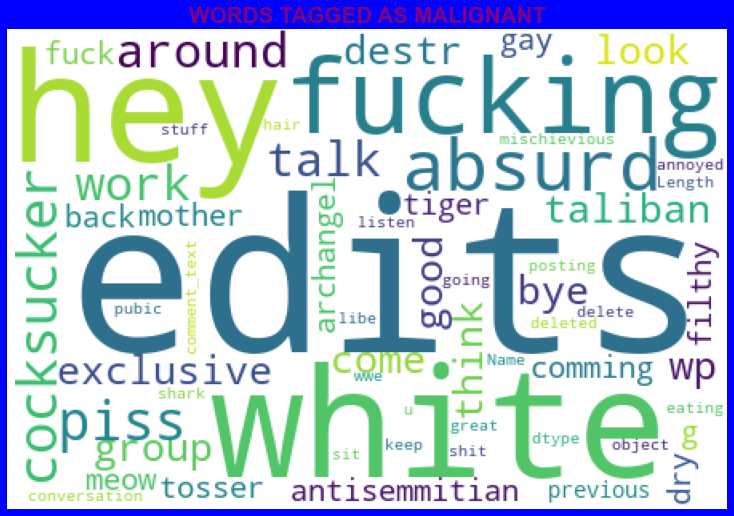

In [35]:
# Plotting for malignant
df_malignant=df[(df['malignant']==1)]
wordcloud=WordCloud(height=300,width=450,max_words=300,background_color="white").generate(str(df_malignant['comment_text']))
plt.figure(figsize=(10,10),facecolor='b')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED AS MALIGNANT',fontdict={'fontsize':22, 'fontweight':'bold', 'color':'purple'})
plt.show()

The above plotting shows WordCloud for WORDS TAGGED AS MALIGNANT.

It is clear that there are mostly words like edits, hey, white, fucking, gay, cocksucker, work, think, taliban, etc.

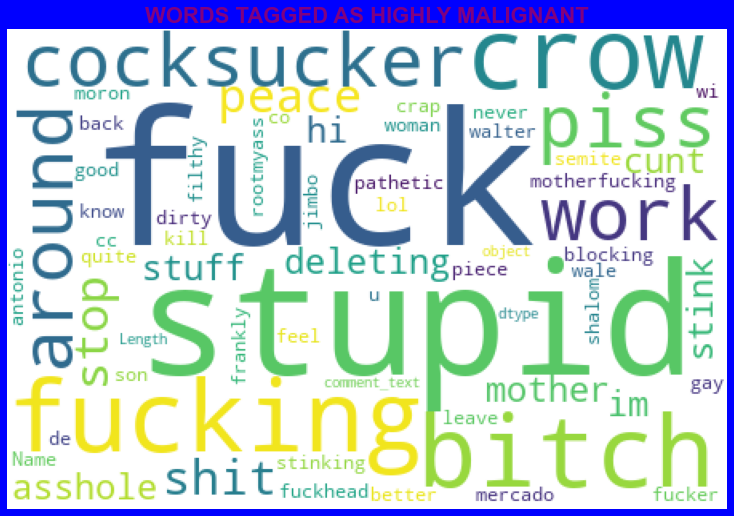

In [36]:
# Plotting for highly_malignant
df_highlymalignant=df[(df['highly_malignant']==1)]
wordcloud=WordCloud(height=300,width=450,max_words=300,background_color="white").generate(str(df_highlymalignant['comment_text']))
plt.figure(figsize=(10,10),facecolor='b')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED AS HIGHLY MALIGNANT',fontdict={'fontsize':22, 'fontweight':'bold', 'color':'purple'})
plt.show()

The above plotting shows WordCloud for WORDS TAGGED AS HIGHLY MALIGNANT

It is clear that there are mostly words like stupid, fuck, fucking, bitch, crow, shit, etc.

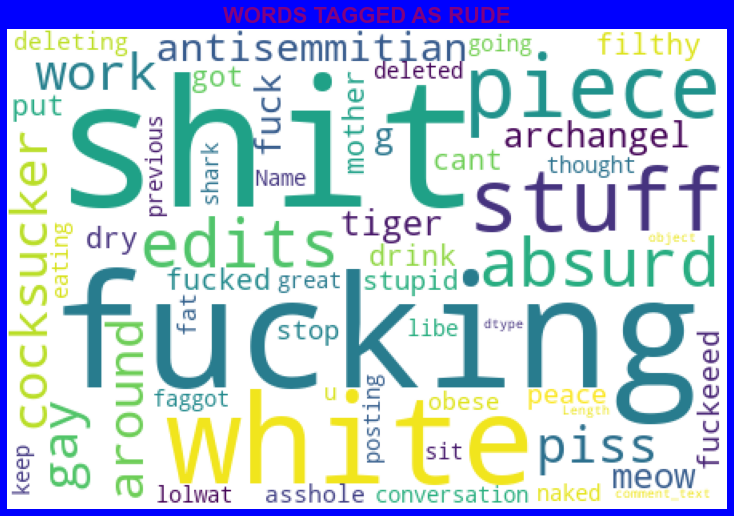

In [37]:
# Plotting for rude
df_rude=df[(df['rude']==1)]
wordcloud=WordCloud(height=300,width=450,max_words=300,background_color="white").generate(str(df_rude['comment_text']))
plt.figure(figsize=(10,10),facecolor='b')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED AS RUDE',fontdict={'fontsize':22, 'fontweight':'bold', 'color':'purple'})
plt.show()

The above plotting shows WordCloud for WORDS TAGGED AS RUDE

It is clear that there are mostly words like fucking, shit, white, piece, edits, stuff, absurd, etc.

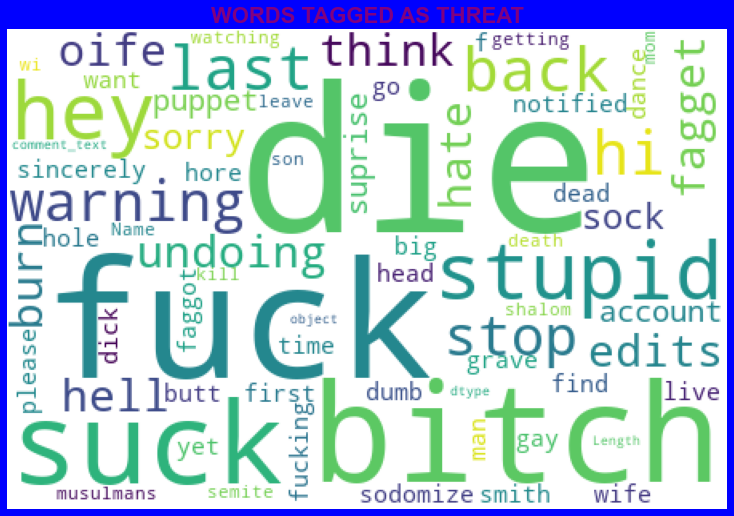

In [38]:
# Plotting for threat
df_threat=df[(df['threat']==1)]
wordcloud=WordCloud(height=300,width=450,max_words=300,background_color="white").generate(str(df_threat['comment_text']))
plt.figure(figsize=(10,10),facecolor='b')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED AS THREAT',fontdict={'fontsize':22, 'fontweight':'bold', 'color':'purple'})
plt.show()

The above plotting shows WordCloud for WORDS TAGGED AS THREAT

It is clear that there are mostly words like fuck, suck, Bitch, die, stupid, etc.

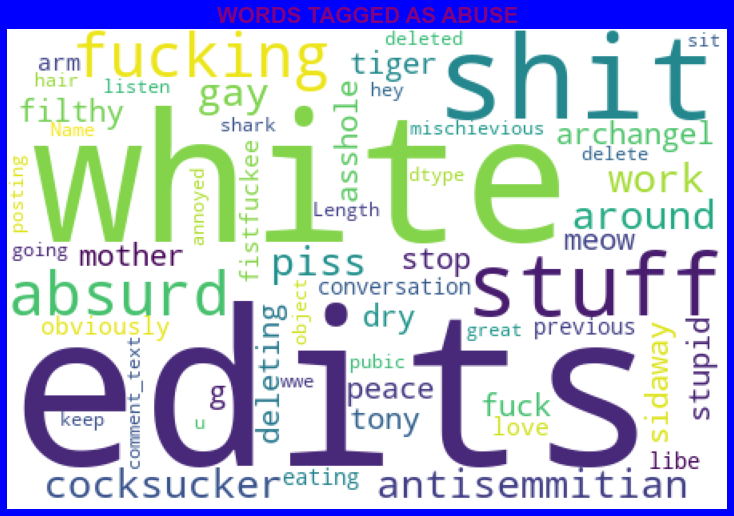

In [39]:
# Plotting for abuse
df_abuse=df[(df['abuse']==1)]
wordcloud=WordCloud(height=300,width=450,max_words=300,background_color="white").generate(str(df_abuse['comment_text']))
plt.figure(figsize=(10,10),facecolor='b')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED AS ABUSE',fontdict={'fontsize':22, 'fontweight':'bold', 'color':'purple'})
plt.show()

The above plotting shows WordCloud for WORDS TAGGED AS ABUSE

It is clear that there are mostly words like edits, white, shit, stuff, fuck, piss, fucking etc.

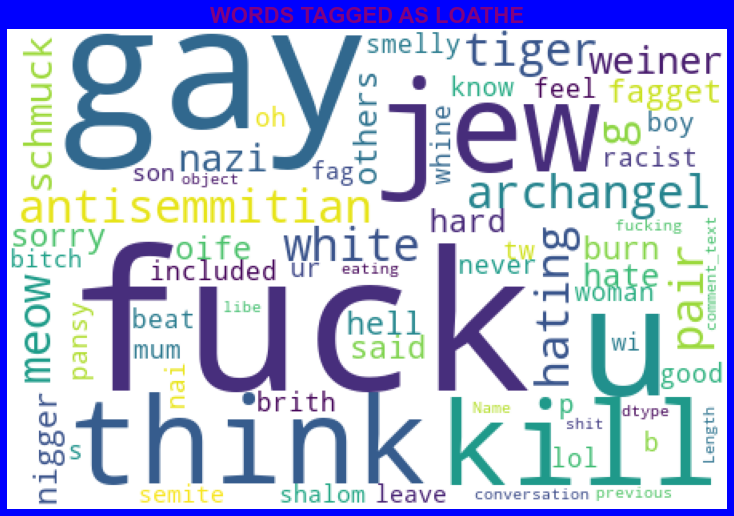

In [40]:
# Plotting for loathe
df_loathe=df[(df['loathe']==1)]
wordcloud=WordCloud(height=300,width=450,max_words=300,background_color="white").generate(str(df_loathe['comment_text']))
plt.figure(figsize=(10,10),facecolor='b')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED AS LOATHE',fontdict={'fontsize':22, 'fontweight':'bold', 'color':'purple'})
plt.show()

The above plotting shows WordCloud for WORDS TAGGED AS LOATHE

It is clear that there are mostly consists of words like fuck, u, kill, gay, think, jew, etc.

# Separating independent and dependent variables

1. Vectorizer & Spliting Train dataset

In [41]:
# Converting the features into number vectors
tf_vec = TfidfVectorizer(max_features = 2000, stop_words='english')

In [42]:
# Let's Separate the input and output variables represented by X and y respectively in train data and convert them
X = tf_vec.fit_transform(df['comment_text']).toarray()

In [43]:
output_labels= df.columns[1:7]

In [44]:
# output variables
from scipy.sparse import csr_matrix
Y = csr_matrix(df[output_labels]).toarray()

# checking shapes of input and output variables to take care of data imbalance issue
print("Input Variable Shape:", X.shape)
print("Output Variable Shape:", Y.shape)

Input Variable Shape: (159571, 2000)
Output Variable Shape: (159571, 6)


2. Vectorizer & Spliting Train dataset

In [45]:
# Doing the above process for test data 
test_vec = tf_vec.fit_transform(df_test['comment_text'])
test_vec

<153164x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 2138199 stored elements in Compressed Sparse Row format>

In [46]:
test_vec.shape

(153164, 2000)

# Model Building

In [47]:
#Importing Machine learning Model library
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import hamming_loss, log_loss

In [48]:
import timeit, sys
import tqdm.notebook as tqdm

In [49]:
# 3. Training and Testing Model on our train dataset

# Creating a function to train and test model
def build_models(models,x,y,test_size=0.33,random_state=42):
    # spliting train test data using train_test_split
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=test_size,random_state=random_state)
    
    # training models using BinaryRelevance of problem transform
    for i in tqdm.tqdm(models,desc="Building Models"):
        start_time = timeit.default_timer()
        
        sys.stdout.write("\n=======================================================================================\n")
        sys.stdout.write(f"Current Model in Progress: {i} ")
        sys.stdout.write("\n=======================================================================================\n")
        
        br_clf = BinaryRelevance(classifier=models[i]["name"],require_dense=[True,True])
        print("Training: ",br_clf)
        br_clf.fit(x_train,y_train)
        
        print("Testing: ")
        predict_y = br_clf.predict(x_test)
        
        ham_loss = hamming_loss(y_test,predict_y)
        sys.stdout.write(f"\n\tHamming Loss  : {ham_loss}")
                
        ac_score = accuracy_score(y_test,predict_y)
        sys.stdout.write(f"\n\tAccuracy Score: {ac_score}")
        
        cl_report = classification_report(y_test,predict_y)
        sys.stdout.write(f"\n{cl_report}")
        
        end_time = timeit.default_timer()
        sys.stdout.write(f"Completed in [{end_time-start_time} sec.]")
        
        models[i]["trained"] = br_clf
        models[i]["hamming_loss"] = ham_loss
        models[i]["accuracy_score"] = ac_score
        models[i]["classification_report"] = cl_report
        models[i]["predict_y"] = predict_y
        models[i]["time_taken"] = end_time - start_time
                      
        sys.stdout.write("\n=======================================================================================\n")
    
    models["x_train"] = x_train
    models["y_train"] = y_train
    models["x_test"] = x_test
    models["y_test"] = y_test
    
    return models

In [50]:
# Preparing the list of models for classification purpose
models = {
          "Logistic Regression": {"name": LogisticRegression()},
          "Random Forest Classifier": {"name": RandomForestClassifier()},
          "Support Vector Classifier": {"name": LinearSVC(max_iter = 3000)},
          "Ada Boost Classifier": {"name": AdaBoostClassifier()},
         }

# Taking one forth of the total data for training and testing purpose
half = len(df)//4
trained_models = build_models(models,X[:half,:],Y[:half,:])

Building Models:   0%|          | 0/4 [00:01<?, ?it/s]


Current Model in Progress: Logistic Regression 
Training:  BinaryRelevance(classifier=LogisticRegression(), require_dense=[True, True])
Testing: 

	Hamming Loss  : 0.022066084314470186
	Accuracy Score: 0.9123433345993164
              precision    recall  f1-score   support

           0       0.92      0.51      0.66      1281
           1       0.61      0.18      0.28       150
           2       0.95      0.54      0.69       724
           3       0.00      0.00      0.00        44
           4       0.81      0.45      0.58       650
           5       0.88      0.13      0.22       109

   micro avg       0.89      0.47      0.61      2958
   macro avg       0.70      0.30      0.40      2958
weighted avg       0.87      0.47      0.60      2958
 samples avg       0.05      0.04      0.04      2958
Completed in [26.747912900000017 sec.]

Current Model in Progress: Random Forest Classifier 
Training:  BinaryRelevance(classifier=RandomForestClassifier(), require_dense=[True, True

From the above model comparision it is clear that Linear Support Vector Classifier performs better with Accuracy Score: 91.15077857956704 % and Hamming Loss: 2.0952019242942144 % than the other classification models.

Therefore, I am now going to use Linear Support Vector Classifier for further Hyperparameter tuning process.

In [51]:
from sklearn.model_selection import  GridSearchCV

fmod_param = {'estimator__penalty' : ['l1', 'l2'],
              'estimator__loss' : ['hinge', 'squared_hinge'],
              'estimator__multi_class' : ['ovr', 'crammer_singer'],
              'estimator__random_state' : [42, 72, 111] }
#SVC = BinaryRelevance(classifier=LinearSVC(),require_dense=[True,True])           
SVC = OneVsRestClassifier(LinearSVC())
GSCV = GridSearchCV(SVC, fmod_param, cv=3,verbose = 10)
x_train,x_test,y_train,y_test = train_test_split(X[:half,:], Y[:half,:], test_size=0.30, random_state=42)
GSCV.fit(x_train,y_train)
GSCV.best_params_

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3; 1/24] START estimator__loss=hinge, estimator__multi_class=ovr, estimator__penalty=l1, estimator__random_state=42
[CV 1/3; 1/24] END estimator__loss=hinge, estimator__multi_class=ovr, estimator__penalty=l1, estimator__random_state=42;, score=nan total time=   1.3s
[CV 2/3; 1/24] START estimator__loss=hinge, estimator__multi_class=ovr, estimator__penalty=l1, estimator__random_state=42
[CV 2/3; 1/24] END estimator__loss=hinge, estimator__multi_class=ovr, estimator__penalty=l1, estimator__random_state=42;, score=nan total time=   0.2s
[CV 3/3; 1/24] START estimator__loss=hinge, estimator__multi_class=ovr, estimator__penalty=l1, estimator__random_state=42
[CV 3/3; 1/24] END estimator__loss=hinge, estimator__multi_class=ovr, estimator__penalty=l1, estimator__random_state=42;, score=nan total time=   0.1s
[CV 1/3; 2/24] START estimator__loss=hinge, estimator__multi_class=ovr, estimator__penalty=l1, estimator__random_state=7

[CV 3/3; 10/24] END estimator__loss=hinge, estimator__multi_class=crammer_singer, estimator__penalty=l2, estimator__random_state=42;, score=0.912 total time=   3.4s
[CV 1/3; 11/24] START estimator__loss=hinge, estimator__multi_class=crammer_singer, estimator__penalty=l2, estimator__random_state=72
[CV 1/3; 11/24] END estimator__loss=hinge, estimator__multi_class=crammer_singer, estimator__penalty=l2, estimator__random_state=72;, score=0.914 total time=   5.1s
[CV 2/3; 11/24] START estimator__loss=hinge, estimator__multi_class=crammer_singer, estimator__penalty=l2, estimator__random_state=72
[CV 2/3; 11/24] END estimator__loss=hinge, estimator__multi_class=crammer_singer, estimator__penalty=l2, estimator__random_state=72;, score=0.915 total time=   4.8s
[CV 3/3; 11/24] START estimator__loss=hinge, estimator__multi_class=crammer_singer, estimator__penalty=l2, estimator__random_state=72
[CV 3/3; 11/24] END estimator__loss=hinge, estimator__multi_class=crammer_singer, estimator__penalty=l2

[CV 1/3; 20/24] END estimator__loss=squared_hinge, estimator__multi_class=crammer_singer, estimator__penalty=l1, estimator__random_state=72;, score=0.914 total time=   5.1s
[CV 2/3; 20/24] START estimator__loss=squared_hinge, estimator__multi_class=crammer_singer, estimator__penalty=l1, estimator__random_state=72
[CV 2/3; 20/24] END estimator__loss=squared_hinge, estimator__multi_class=crammer_singer, estimator__penalty=l1, estimator__random_state=72;, score=0.915 total time=   4.6s
[CV 3/3; 20/24] START estimator__loss=squared_hinge, estimator__multi_class=crammer_singer, estimator__penalty=l1, estimator__random_state=72
[CV 3/3; 20/24] END estimator__loss=squared_hinge, estimator__multi_class=crammer_singer, estimator__penalty=l1, estimator__random_state=72;, score=0.912 total time=   2.9s
[CV 1/3; 21/24] START estimator__loss=squared_hinge, estimator__multi_class=crammer_singer, estimator__penalty=l1, estimator__random_state=111
[CV 1/3; 21/24] END estimator__loss=squared_hinge, est

{'estimator__loss': 'hinge',
 'estimator__multi_class': 'ovr',
 'estimator__penalty': 'l2',
 'estimator__random_state': 42}

# Final Model

In [52]:
Final_Model = OneVsRestClassifier(LinearSVC(loss='hinge', 
            multi_class='ovr', penalty='l2', random_state=42))

Classifier = Final_Model.fit(x_train, y_train)
fmod_pred = Final_Model.predict(x_test)
fmod_acc = (accuracy_score(y_test, fmod_pred))*100
print("Accuracy score for the Best Model is:", fmod_acc)
h_loss = hamming_loss(y_test,fmod_pred)*100
print("Hamming loss for the Best Model is:", h_loss)

Accuracy score for the Best Model is: 91.26002673796792
Hamming loss for the Best Model is: 2.0819407308377897


Final Model is giving us Accuracy score of 91.26% which is slightly improved compare to earlier Accuracy score of 91.15%.

# Confusion Matrix of Final Model

In [53]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, multilabel_confusion_matrix
print("Confusion matrix:\n\n", multilabel_confusion_matrix(y_test, fmod_pred))

Confusion matrix:

 [[[10720    73]
  [  507   668]]

 [[11833     0]
  [  135     0]]

 [[11268    42]
  [  231   427]]

 [[11930     0]
  [   38     0]]

 [[11274    98]
  [  289   307]]

 [[11869     3]
  [   79    17]]]


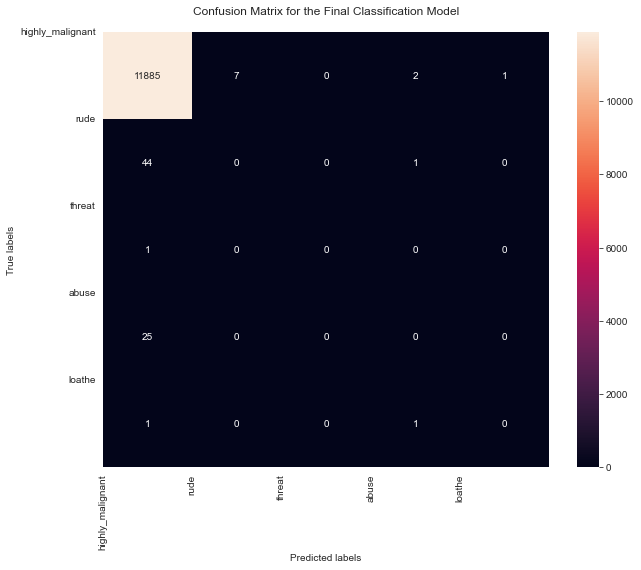

In [54]:
plt.rcParams["figure.figsize"] = (10,8) # used to change the output figure size
ax= plt.subplot()
cm = confusion_matrix(np.asarray(y_test).argmax(axis=1), np.asarray(fmod_pred).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  # annot=True to annotate cells, ftm='g' to disable scientific notation

# title, labels and ticks
ax.set_title('Confusion Matrix for the Final Classification Model\n'); 
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels'); 
loc = plticker.MultipleLocator()
ax.xaxis.set_major_locator(loc); ax.yaxis.set_major_locator(loc);
ax.set_xticklabels(comments_labels); ax.set_yticklabels(comments_labels);
plt.xticks(rotation=90); plt.yticks(rotation=0);
plt.show()

# Saving Model 

In [55]:
# selecting the best model
best_model = trained_models['Support Vector Classifier']['trained']

# saving the best classification model
import joblib
joblib.dump(best_model,open('Malignant_comments_classifier.pkl','wb'))

# Test Dataset Predictions

In [56]:
# saving the best classification model
import joblib
best_model = joblib.load('Malignant_comments_classifier.pkl')
#joblib.dump(best_model,open('Malignant_comments_classifier.pkl','wb'))

In [57]:
test_vec.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [58]:
# Make predictions and view the results
predict_test = best_model.predict(test_vec.toarray())

# Saving predicted values into a CSV file
pd.DataFrame(predict_test).to_csv('Predicted_test_output.csv')

In [59]:
df1 = pd.read_csv('Predicted_test_output.csv')
df1.drop("Unnamed: 0", axis=1, inplace=True)
df1.rename({'0':'malignant', '1':'highly_malignant', '2':'rude', '3':'threat', '4':'abuse', '5':'loathe'}, 
           axis='columns', inplace=True)
df2=df_test.copy()
df = pd.concat([df2, df1], axis=1)
df

,comment_text,length_before_cleaning,length_after_cleaning,malignant
0,yo bitch ja rule succesful ever whats hating s...,367,235,NaN
1,rfc title fine imo,50,18,NaN
2,source zawe ashton lapland,54,26,NaN
3,look back source information updated correct f...,205,109,NaN
4,anonymously edit article,41,24,NaN
...,...,...,...,...
153159,totally agree stuff nothing long crap,60,37,NaN
153160,throw field home plate get faster throwing cut...,198,107,NaN
153161,okinotorishima category see change agree corre...,423,238,NaN
153162,one founding nation eu germany law return quit...,502,319,NaN


In [60]:
df.to_csv('Test_dataset_predictions2.csv', index=False)

Finally, we have predicted the test data and the predictions obtained were saved in a csv file.